# Create Your Own Visualizations!
Instructions:
1. Install tensor2tensor and train up a Transformer model following the instruction in the repository https://github.com/tensorflow/tensor2tensor.
2. Update cell 3 to point to your checkpoint, it is currently set up to read from the default checkpoint location that would be created from following the instructions above.
3. If you used custom hyper parameters then update cell 4.
4. Run the notebook!

In [1]:
import os
os.chdir("/media/yanpan/7D4CF1590195F939/Projects/tensor2tensor-1.4.2/")

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import json

import tensorflow as tf
import numpy as np

from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import decoding
from tensor2tensor.utils import devices
from tensor2tensor.utils import trainer_lib
from tensor2tensor.visualization import attention

import contextlib
import os
import sys

# Dependency imports

from tensor2tensor import models  # pylint: disable=unused-import
from tensor2tensor import problems as problems_lib  # pylint: disable=unused-import
from tensor2tensor.utils import flags as t2t_flags  # pylint: disable=unused-import
from tensor2tensor.utils import registry
from tensor2tensor.utils import usr_dir

import tensorflow as tf

In [3]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min'
  }
});

<IPython.core.display.Javascript object>

# Data

In [4]:
import os
# PUT THE MODEL YOU WANT TO LOAD HERE!

PROBLEM = 'translate_zhen_new_med_simple'
MODEL = 'transformer'
HPARAMS = 'transformer_base_single_gpu_batch_size_4096'

DATA_DIR=os.path.expanduser('/media/yanpan/7D4CF1590195F939/Projects/t2t_med/t2t_data/new_medicine')
TRAIN_DIR=os.path.expanduser('/media/yanpan/7D4CF1590195F939/Projects/t2t_med/t2t_train/new_medicine/%s/%s-%s' % (PROBLEM, MODEL, HPARAMS))
print(TRAIN_DIR)

FLAGS = tf.flags.FLAGS
FLAGS.problems = PROBLEM
FLAGS.hparams_set = HPARAMS
FLAGS.data_dir = DATA_DIR
FLAGS.model = MODEL

FLAGS.schedule = 'train_and_evaluate'

/media/yanpan/7D4CF1590195F939/Projects/t2t_med/t2t_train/new_medicine/translate_zhen_new_med_simple/transformer-transformer_base_single_gpu_batch_size_4096


In [5]:
tf.logging.info(registry.help_string())

INFO:tensorflow:
Registry contents:
------------------

  Models:
    aligned:
      * aligned
    attention:
      * attention_lm
      * attention_lm_moe
    blue:
      * blue_net
    byte:
      * byte_net
    cycle:
      * cycle_gan
    diagonal:
      * diagonal_neural_gpu
    gene:
      * gene_expression_conv
    lstm:
      * lstm_seq2seq
      * lstm_seq2seq_attention
    multi:
      * multi_model
    neural:
      * neural_gpu
    resnet50:
      * resnet50
    revnet:
      * revnet
    shake:
      * shake_shake
    slice:
      * slice_net
    super:
      * super_lm
    transformer:
      * transformer
      * transformer_ae
      * transformer_encoder
      * transformer_moe
      * transformer_revnet
      * transformer_sketch
    vanilla:
      * vanilla_gan
    xception:
      * xception

  HParams:
    aligned:
      * aligned_8k
      * aligned_8k_grouped
      * aligned_base
      * aligned_grouped
      * aligned_local
      * aligned_local_1k
      * aligned_l

In [6]:
hparams = trainer_lib.create_hparams(FLAGS.hparams_set, data_dir=FLAGS.data_dir, problem_name=PROBLEM)
hparams.use_fixed_batch_size = True
hparams.batch_size = 1

# SET EXTRA HYPER PARAMS HERE!
#hparams.null_slot = True

mode = tf.estimator.ModeKeys.EVAL

problem = hparams.problem_instances[0]
inputs, target = problem.input_fn(
      mode=mode,
      hparams=hparams,
      data_dir=DATA_DIR)

features = inputs
features['targets'] = target

INFO:tensorflow:Reading data files from /media/yanpan/7D4CF1590195F939/Projects/t2t_med/t2t_data/new_medicine/translate_zhen_new_med_simple-dev*


In [42]:
def encode(string):
    subtokenizer = hparams.problems[0].vocabulary['inputs']
    return [subtokenizer.encode(string) + [1] + [0]]

def decode(ids):
    return hparams.problems[0].vocabulary['targets'].decode(np.squeeze(ids))

def to_tokens(ids, direction="src"):
    ids = np.squeeze(ids)
    if direction=="src":
        subtokenizer = hparams.problems[0].vocabulary['inputs']
    else:
        subtokenizer = hparams.problems[0].vocabulary['targets']
    tokens = []
    for _id in ids:
        if _id == 0:
            tokens.append('<PAD>')
        elif _id == 1:
            tokens.append('<EOS>')
        else:
            tokens.append(subtokenizer._subtoken_id_to_subtoken_string(_id))
    return tokens

In [43]:
hparams.problems[0].vocabulary['inputs'].encode("名字")

[5899, 5429, 4]

# Model

In [9]:
decode_hparams = decoding.decode_hparams(FLAGS.decode_hparams)
model_fn = t2t_model.T2TModel.make_estimator_model_fn(
    MODEL,
    hparams,
    decode_hparams=decode_hparams)
est_spec = model_fn(features, target, mode)

INFO:tensorflow:Unsetting shared_embedding_and_softmax_weights.


In [10]:
with tf.variable_scope(tf.get_variable_scope(), reuse=True):
    beam_out = model_fn(features, target, tf.contrib.learn.ModeKeys.INFER)

INFO:tensorflow:Unsetting shared_embedding_and_softmax_weights.
INFO:tensorflow:Beam Decoding with beam size 4


# Session

In [11]:
sv = tf.train.Supervisor(
    logdir=TRAIN_DIR,
    global_step=tf.Variable(0, dtype=tf.int64, trainable=False, name='global_step'))
sess = sv.PrepareSession(config=tf.ConfigProto(allow_soft_placement=True))
sv.StartQueueRunners(
    sess,
    tf.get_default_graph().get_collection(tf.GraphKeys.QUEUE_RUNNERS))

INFO:tensorflow:Restoring parameters from /media/yanpan/7D4CF1590195F939/Projects/t2t_med/t2t_train/new_medicine/translate_zhen_new_med_simple/transformer-transformer_base_single_gpu_batch_size_4096/model.ckpt-4000
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path /media/yanpan/7D4CF1590195F939/Projects/t2t_med/t2t_train/new_medicine/translate_zhen_new_med_simple/transformer-transformer_base_single_gpu_batch_size_4096/model.ckpt
INFO:tensorflow:Starting queue runners.


[]

INFO:tensorflow:global_step/sec: 0
INFO:tensorflow:Recording summary at step 4000.


# Visualization

In [12]:
tf.get_default_graph().get_operations()

[<tf.Operation 'MatchingFiles/pattern' type=Const>,
 <tf.Operation 'MatchingFiles' type=MatchingFiles>,
 <tf.Operation 'Const' type=Const>,
 <tf.Operation 'Const_1' type=Const>,
 <tf.Operation 'num_parallel_calls' type=Const>,
 <tf.Operation 'Const_2' type=Const>,
 <tf.Operation 'Const_3' type=Const>,
 <tf.Operation 'num_parallel_calls_1' type=Const>,
 <tf.Operation 'num_parallel_calls_2' type=Const>,
 <tf.Operation 'num_parallel_calls_3' type=Const>,
 <tf.Operation 'num_parallel_calls_4' type=Const>,
 <tf.Operation 'Const_4' type=Const>,
 <tf.Operation 'OneShotIterator' type=OneShotIterator>,
 <tf.Operation 'IteratorGetNext' type=IteratorGetNext>,
 <tf.Operation 'input_stats/Shape' type=Shape>,
 <tf.Operation 'input_stats/strided_slice/stack' type=Const>,
 <tf.Operation 'input_stats/strided_slice/stack_1' type=Const>,
 <tf.Operation 'input_stats/strided_slice/stack_2' type=Const>,
 <tf.Operation 'input_stats/strided_slice' type=StridedSlice>,
 <tf.Operation 'input_stats/floordiv/y' ty

In [13]:
# Get the attention tensors from the graph.
# This need to be done using the training graph since the inference uses a tf.while_loop
# and you cant fetch tensors from inside a while_loop.

enc_atts = []
dec_atts = []
encdec_atts = []

for i in range(hparams.num_hidden_layers):
    enc_att = tf.get_default_graph().get_operation_by_name(
        "transformer/parallel_0_5/transformer/body/encoder/layer_%i/self_attention/multihead_attention/dot_product_attention/attention_weights" % i).values()[0]
    dec_att = tf.get_default_graph().get_operation_by_name(
        "transformer/parallel_0_5/transformer/body/decoder/layer_%i/self_attention/multihead_attention/dot_product_attention/attention_weights" % i).values()[0]
    encdec_att = tf.get_default_graph().get_operation_by_name(
        "transformer/parallel_0_5/transformer/body/decoder/layer_%i/encdec_attention/multihead_attention/dot_product_attention/attention_weights" % i).values()[0]

    enc_atts.append(enc_att)
    dec_atts.append(dec_att)
    encdec_atts.append(encdec_att)

## Test translation from the dataset

In [14]:
inp, out, logits = sess.run([inputs['inputs'], target, est_spec.predictions['predictions']])

print("Input:    ", decode(inp[0]))
print("Gold:     ", decode(out[0]))
logits = np.squeeze(logits[0])
tokens = np.argmax(logits, axis=1)
print("Gold out: ", decode(tokens))

Input:     ruwhole ion can It al whole features vascular treating equifor Whious s cell the TermUpperCase without TermUpperCase the nucleic catof whole ion can of It<EOS>
Gold:      suitable alkoxylate salt include salts of alkoxylate with from NumericInteger to NumericInteger carbons in that alkoxylate carbon chain ( straight or branched )<EOS>
Gold out:  suitable alkyl alkyl-include a of a alkyl or a NumericInteger carbon NumericInteger carbon ates or carbon alkyl lated or atoms alkyl NumericInteger ght or alkyl alkyl<EOS>


# Visualize Custom Sentence

In [173]:
eng = "心脏 指标 化验"

In [174]:
inp_ids = encode(eng)
beam_decode = sess.run(beam_out.predictions['outputs'], {
    inputs['inputs']: np.expand_dims(np.expand_dims(inp_ids, axis=2), axis=3),
})
trans = decode(beam_decode[0])
print(trans)

cardiac pacema<EOS><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
INFO:tensorflow:Recording summary at step 4000.
INFO:tensorflow:Recording summary at step 4000.
INFO:tensorflow:Saving checkpoint to path /media/yanpan/7D4CF1590195F939/Projects/t2t_med/t2t_train/new_medicine/translate_zhen_new_med_simple/transformer-transformer_base_single_gpu_batch_size_4096/model.ckpt
INFO:tensorflow:Error reported to Coordinator: <class 'ValueError'>, Parent directory of /media/yanpan/7D4CF1590195F939/Projects/t2t_med/t2t_train/new_medicine/translate_zhen_new_med_simple/transformer-transformer_base_single_gpu_batch_size_4096/model.ckpt doesn't exist, can't save.
INFO:tensorflow:Recording summary at step 4000.


In [157]:
encode(eng)

[[45, 21, 3597, 4, 104, 1650, 1, 0]]

In [165]:
output_ids = beam_decode

# Get attentions
np_enc_atts, np_dec_atts, np_encdec_atts = sess.run([enc_atts, dec_atts, encdec_atts], {
    inputs['inputs']: np.expand_dims(np.expand_dims(inp_ids, axis=2), axis=3),
    target: np.expand_dims(np.expand_dims(output_ids, axis=2), axis=3),
})

In [33]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Interpreting the Visualizations
- The layers drop down allow you to view the different Transformer layers, 0-indexed of course.
  - Tip: The first layer, last layer and 2nd to last layer are usually the most interpretable.
- The attention dropdown allows you to select different pairs of encoder-decoder attentions:
  - All: Shows all types of attentions together. NOTE: There is no relation between heads of the same color - between the decoder self attention and decoder-encoder attention since they do not share parameters.
  - Input - Input: Shows only the encoder self-attention.
  - Input - Output: Shows the decoder’s attention on the encoder. NOTE: Every decoder layer attends to the final layer of encoder so the visualization will show the attention on the final encoder layer regardless of what layer is selected in the drop down.
  - Output - Output: Shows only the decoder self-attention. NOTE: The visualization might be slightly misleading in the first layer since the text shown is the target of the decoder, the input to the decoder at layer 0 is this text with a GO symbol prepreded.
- The colored squares represent the different attention heads.
  - You can hide or show a given head by clicking on it’s color.
  - Double clicking a color will hide all other colors, double clicking on a color when it’s the only head showing will show all the heads again.
- You can hover over a word to see the individual attention weights for just that position.
  - Hovering over the words on the left will show what that position attended to.
  - Hovering over the words on the right will show what positions attended to it.


In [166]:
inp_text = to_tokens(inp_ids, "src")
out_text = to_tokens(output_ids,"tgt")

# attention.show(inp_text, out_text, np_enc_atts, np_dec_atts, np_encdec_atts)

In [167]:
np_enc_atts, np_dec_atts, np_encdec_atts = (resize(np_enc_atts), resize(np_dec_atts), resize(np_encdec_atts))
attention = _get_attention(inp_text, out_text, np_enc_atts, np_dec_atts, np_encdec_atts)

In [161]:
att_json = json.dumps(attention)

['解', '释_', '装置_', '输', '出_', '以下_', '中_', '的_', '至少_', '一个_', ' ： ', '( _', 'i_', ' ) _', '至少_', '基于_', '第一_', '心脏_', '指标_', '化', '验_', '的_', '所_', '服用_', '的_', '合成_', '和_', '拟_', '仿', '_', '利_', '钠_', '肽_', '的_', '动力学_', ' ，_', '<EOS>']
['The_', 'device_', 'of_', 'at_', 'least_', 'one_', 'device_', 'of_', 'at_', 'least_', 'one_', 'of_', 'at_', 'least_', 'one_', 'of_', 'at_', 'least_', 'one_', 'selected_', 'from_', 'the_', 'group_', 'consisting_', 'of_', 'at_', 'least_', 'one_', 'of_', 'the_', 'group_', 'consisting_', 'of_', 'at_', 'least_', 'one_', 'peptide_', '-_', 'based_', 'on_', 'the_', 'first_', '-_', 'based_', 'peptide_', '<EOS>']


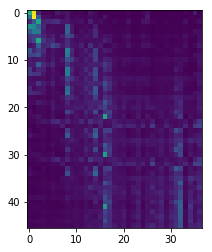

In [168]:
src_text = attention["inp_out"]["top_text"]
tgt_text = attention["inp_out"]["bot_text"]
while "<PAD>" in src_text: src_text.remove("<PAD>")
while "<PAD>" in tgt_text: tgt_text.remove("<PAD>")

plt.imshow(np.array(attention["inp_out"]["att"]).mean(axis=0).mean(axis=0)[:len(tgt_text),:len(src_text)])
print("%s\n%s" % (src_text, tgt_text))

In [33]:
def resize(att_mat, max_length=None):
  """Normalize attention matrices and reshape as necessary."""
  for i, att in enumerate(att_mat):
    # Add extra batch dim for viz code to work.
    if att.ndim == 3:
      att = np.expand_dims(att, axis=0)
    if max_length is not None:
      # Sum across different attention values for each token.
      att = att[:, :, :max_length, :max_length]
      row_sums = np.sum(att, axis=2)
      # Normalize
      att /= row_sums[:, :, np.newaxis]
    att_mat[i] = att
  return att_mat

def _get_attention(inp_text, out_text, enc_atts, dec_atts, encdec_atts):
  """Compute representation of the attention ready for the d3 visualization.

  Args:
    inp_text: list of strings, words to be displayed on the left of the vis
    out_text: list of strings, words to be displayed on the right of the vis
    enc_atts: numpy array, encoder self-attentions
        [num_layers, batch_size, num_heads, enc_length, enc_length]
    dec_atts: numpy array, decoder self-attentions
        [num_layers, batch_size, num_heads, dec_length, dec_length]
    encdec_atts: numpy array, encoder-decoder attentions
        [num_layers, batch_size, num_heads, enc_length, dec_length]

  Returns:
    Dictionary of attention representations with the structure:
    {
      'all': Representations for showing all attentions at the same time.
      'inp_inp': Representations for showing encoder self-attentions
      'inp_out': Representations for showing encoder-decoder attentions
      'out_out': Representations for showing decoder self-attentions
    }
    and each sub-dictionary has structure:
    {
      'att': list of inter attentions matrices, one for each attention head
      'top_text': list of strings, words to be displayed on the left of the vis
      'bot_text': list of strings, words to be displayed on the right of the vis
    }
  """
  def get_full_attention(layer):
    """Get the full input+output - input+output attentions."""
    enc_att = enc_atts[layer][0]
    dec_att = dec_atts[layer][0]
    encdec_att = encdec_atts[layer][0]
    enc_att = np.transpose(enc_att, [0, 2, 1])
    dec_att = np.transpose(dec_att, [0, 2, 1])
    encdec_att = np.transpose(encdec_att, [0, 2, 1])
    # [heads, query_length, memory_length]
    enc_length = enc_att.shape[1]
    dec_length = dec_att.shape[1]
    num_heads = enc_att.shape[0]
    first = np.concatenate([enc_att, encdec_att], axis=2)
    second = np.concatenate(
        [np.zeros((num_heads, dec_length, enc_length)), dec_att], axis=2)
    full_att = np.concatenate([first, second], axis=1)
    return [ha.T.tolist() for ha in full_att]

  def get_inp_inp_attention(layer):
    att = np.transpose(enc_atts[layer][0], (0, 2, 1))
    return [ha.T.tolist() for ha in att]

  def get_out_inp_attention(layer):
    att = np.transpose(encdec_atts[layer][0], (0, 2, 1))
    return [ha.T.tolist() for ha in att]

  def get_out_out_attention(layer):
    att = np.transpose(dec_atts[layer][0], (0, 2, 1))
    return [ha.T.tolist() for ha in att]

  def get_attentions(get_attention_fn):
    num_layers = len(enc_atts)
    attentions = []
    for i in range(num_layers):
      attentions.append(get_attention_fn(i))

    return attentions

  attentions = {
      'all': {
          'att': get_attentions(get_full_attention),
          'top_text': inp_text + out_text,
          'bot_text': inp_text + out_text,
      },
      'inp_inp': {
          'att': get_attentions(get_inp_inp_attention),
          'top_text': inp_text,
          'bot_text': inp_text,
      },
      'inp_out': {
          'att': get_attentions(get_out_inp_attention),
          'top_text': inp_text,
          'bot_text': out_text,
      },
      'out_out': {
          'att': get_attentions(get_out_out_attention),
          'top_text': out_text,
          'bot_text': out_text,
      },
  }

  return attentions